This notebook is put together by [Zefeng Li](http://web.gps.caltech.edu/~zefengli/) from [Caltech Seismo Lab](http://www.seismolab.caltech.edu/) for the 2019 SSA Machine Learning workshop. If you have any questions, feel free to contact him via zefengli@caltech.edu. 

# Introduction of ML Regression
Supervised ML is basically to find a function f(X)= y that maps your input (X) to your output (y). In classification tasks, which you have seen just now, the prediction target y is categorical. In regression tasks, y is a continuous variable. The basic steps remain largely the same as classification. 

Similar to classifcation, there are a wide variety of choices for models f (ANN, SVM, Decision Tree, Deep networks etc.); you also have choices for the forms of input X, e.g. the objects themselves or the features of the objects. You will see some difference in evaluatation of prediction accuracy from classifiction. 

In the following, we will see examples of magnitude estimation using individual early P waveforms. This is an important but challenging problem in earthquake early warning. We will use the same earthquake waveforms which you used in the previous classification example. Prediction of magnitude from P waveforms is not as intuitive as noise/event classification. It appears to be a difficult task (and it is). We see will how it works.

In [1]:
# import some popular modules that will be useful later
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline

# Read in data

The first step is always reading in the data into a good format so that we can input into ML algorithms. 

In [2]:
import numpy as np
from obspy import read # read sac/mseed/segy etc.
import glob 

training_folder = '../data/training_data_classification_regression/'
waveforms = [] # initilize a empty list to contain data

for item in glob.glob(training_folder + 'seismic/*.mseed'):
    st = read(item)
    st.detrend('demean').detrend('linear')
    waveforms.append([st[0].data[100:400], st[1].data[100:400], st[2].data[100:400]]) # 3-s P wave
    
waveforms = np.asarray(waveforms) # transform list to numpy array

In [3]:
waveforms.shape 

(265, 3, 300)

In [4]:
import pandas as pd
df = pd.read_csv(training_folder + 'EQs_M3_above.csv') # read meta data of the waveforms as data frame

In [5]:
print(df[:3])

  network  stnm channel       dist phase                   phase_time onset  \
0      BK  MNRC     HHZ  31.757232     P  2005-07-23T12:31:34.290000Z   NaN   
1      BK  MNRC     HHZ  61.668538     P  2005-08-25T11:10:53.390000Z   NaN   
2      BK  MNRC     HHZ  33.505025     P  2005-08-29T02:36:31.350000Z   NaN   

   polarity evaluation_mode evaluation_status                       evtime  \
0  negative          manual             final  2005-07-23T12:31:27.830000Z   
1  positive          manual             final  2005-08-25T11:10:41.720000Z   
2  positive          manual             final  2005-08-29T02:36:24.670000Z   

        evla        evlo   mag mag_type   eventId  
0  38.796333 -122.793833  3.19       Ml  21471390  
1  38.362000 -122.185000  3.16       Ml  21479549  
2  38.817167 -122.821500  3.10       Ml  21480285  


In [6]:
y = df['mag']

In [7]:
y.shape

(265,)

## EQ waveform plots
Here we plot out the EQ waveforms to make sure the data are reasonable, also to get a sense of the task complexity.

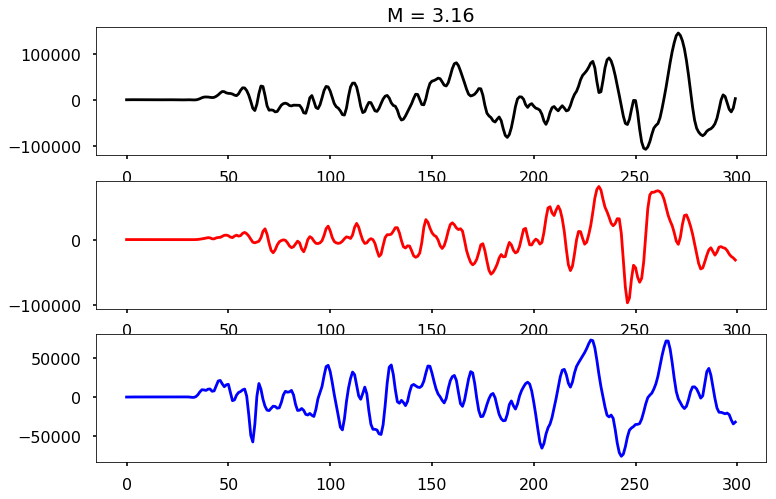

In [8]:
# Earthquake waveform examples
i_record = 100
plt.figure(figsize = (12, 8))
plt.subplot(311)
plt.plot(waveforms[i_record, 0, :], 'k')
plt.title("M = " + str(y[i_record]))
plt.subplot(312)
plt.plot(waveforms[i_record, 1, :], 'r')
plt.subplot(313)
plt.plot(waveforms[i_record, 2, :], 'b')

# Question: Do you see any problem from the above examples?
Unbalanced data is an annoying problem in many ML tasks. We will not try to solve it in this tutorial.

## Next: Get the input (object features vs. objects themselves)
There are basically two types of inputs: a. the features of the object; b. the objects themselves. Let's see the first case.

## Extract features
Here we calculate only 4 features (of course, you can calculate more using tsfresh https://tsfresh.readthedocs.io/): mean value, max value, rms (the same as std), and number of zero crossings. 

In [9]:
def calculate_features(data):
    
    mean_amp = np.apply_along_axis(np.mean, 1, np.abs(data))
    max_amp = np.apply_along_axis(max, 1, np.abs(data))
    std_amp = np.apply_along_axis(np.std, 1, data)
    zero_crossings = lambda data: len(np.where(np.diff(np.sign(data)))[0])
    zc = np.apply_along_axis(zero_crossings, 1, data)
    
    return np.log10(max(mean_amp)), np.log10(max(max_amp)), np.log10(max(std_amp)), max(zc)

In [10]:
# calculate all the features for each record
X = np.array(list(map(calculate_features, waveforms)))
print(X.shape)

(265, 4)


Text(0, 0.5, 'Mag')

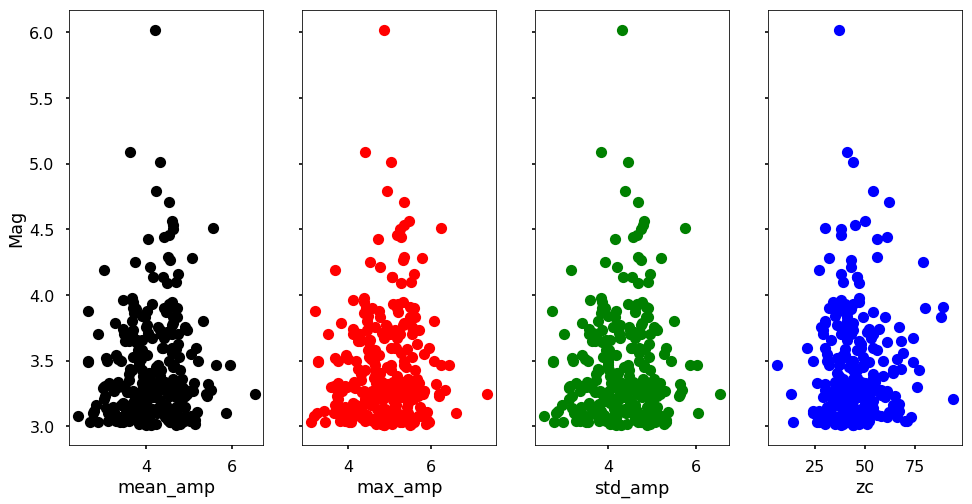

In [11]:
feature_names = ['mean_amp', 'max_amp', 'std_amp', 'zc']
fig, axs = plt.subplots(1, 4, sharey = True, figsize = (16, 8))
for i, c in zip([0, 1, 2, 3], ['k', 'r', 'g', 'b']):
    axs[i].plot(X[:, i], y, 'o', color = c)
    axs[i].set_xlabel(feature_names[i])
axs[0].set_ylabel('Mag')

## Divide training/testing dataset and preprocessing

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [13]:
print(len(X_train), len(X_test))

212 53


In [14]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)
print(X_train_scale.shape)

(212, 4)


Text(0, 0.5, 'mag')

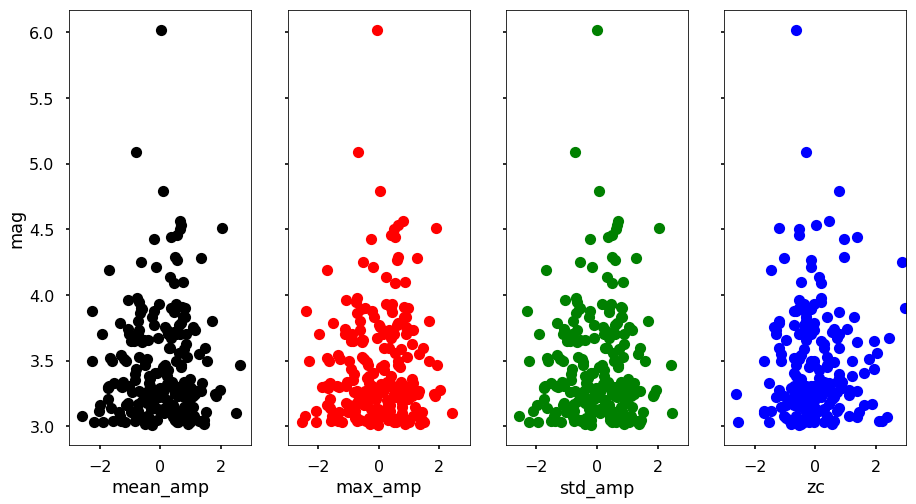

In [15]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize = (15, 8))
for i, c in zip([0, 1, 2, 3], ['k', 'r', 'g', 'b']):
    axs[i].plot(X_train_scale[:, i], y_train, 'o', color = c)
    axs[i].set_xlim([-3, 3])
    axs[i].set_xlabel(feature_names[i])
axs[0].set_ylabel('mag')

# Train a Random Forest model

## Decision Tree
![Desion Tree](https://cdn-images-1.medium.com/max/1600/1*H3nZElqhfOE35AFAq8gy0A.png)
## Random Forest
![Random Forest](https://cdn-images-1.medium.com/max/1600/1*i0o8mjFfCn-uD79-F1Cqkw.png)

Courtesy: Pictures from https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

In [16]:
# Use all the features, scale input
X_train_scale = standard_scaler.fit_transform(X_train)
X_test_scale = standard_scaler.transform(X_test)

In [17]:
# Set the parameters by cross-validation
from sklearn.ensemble import RandomForestRegressor
n_estimators = [10, 20, 40, 80] # stabilize the estimator but increase computational cost
max_depth =[5, 10, 20, 40] # overfit if too high

In [18]:
print("# Tuning hyper-parameters:")
for i_estimators in [10, 20, 50, 100]:
    for i_max_depth in [10, 20, 50]:
        regr = RandomForestRegressor(n_estimators=i_estimators, 
                                    max_depth=i_max_depth, 
                                    random_state=0, 
                                    criterion='mse')
        regr.fit(X_train_scale, y_train) # train
        print('n_estimators = {}, max_depth = {}'.format(i_estimators, i_max_depth))
        # Score: R^2 bt predicted and true values, at best 1. It can be negative.
        print('score on test set: {}'.format(regr.score(X_test_scale, y_test))) 
        print('feature importances: {}'.format(regr.feature_importances_))
        print()


# Tuning hyper-parameters:
n_estimators = 10, max_depth = 10
score on test set: -0.1882676536114436
feature importances: [ 0.25644166  0.27130754  0.26838858  0.20386222]

n_estimators = 10, max_depth = 20
score on test set: -0.13313266695718506
feature importances: [ 0.24154253  0.23276761  0.32077657  0.20491329]

n_estimators = 10, max_depth = 50
score on test set: -0.13313266695718506
feature importances: [ 0.24154253  0.23276761  0.32077657  0.20491329]

n_estimators = 20, max_depth = 10
score on test set: -0.2140948767525246
feature importances: [ 0.24688136  0.30901683  0.24371802  0.20038379]

n_estimators = 20, max_depth = 20
score on test set: -0.1597159742765677
feature importances: [ 0.25049485  0.28363783  0.264473    0.20139432]

n_estimators = 20, max_depth = 50
score on test set: -0.1597159742765677
feature importances: [ 0.25049485  0.28363783  0.264473    0.20139432]

n_estimators = 50, max_depth = 10
score on test set: -0.15165483633617072
feature importances: [ 0.27

## Train and Test the RF model

In [19]:
# Choose a specific setting to show the results
regr = RandomForestRegressor(n_estimators=50, 
                             max_depth=50, 
                             random_state=0, 
                             criterion='mse')
regr.fit(X_train_scale, y_train)
y_pred = regr.predict(X_test_scale)

In [20]:
print('RMSE:', np.std(y_pred-y_test))

RMSE: 0.4368844910570364


Text(0, 0.5, 'y_pred')

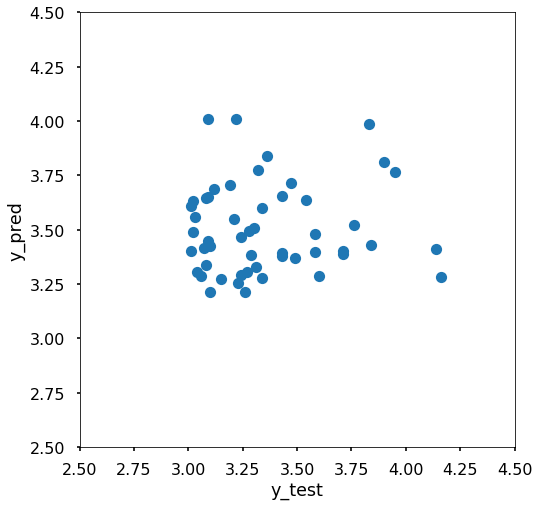

In [21]:
# plot 1-1 comparison
plt.figure(figsize = (12, 8))
plt.plot(y_test, y_pred, 'o')
plt.axis('square')
plt.xlim([2.5, 4.5])
plt.ylim([2.5, 4.5])
plt.xlabel('y_test')
plt.ylabel('y_pred')

Text(0.5, 0, 'y residual')

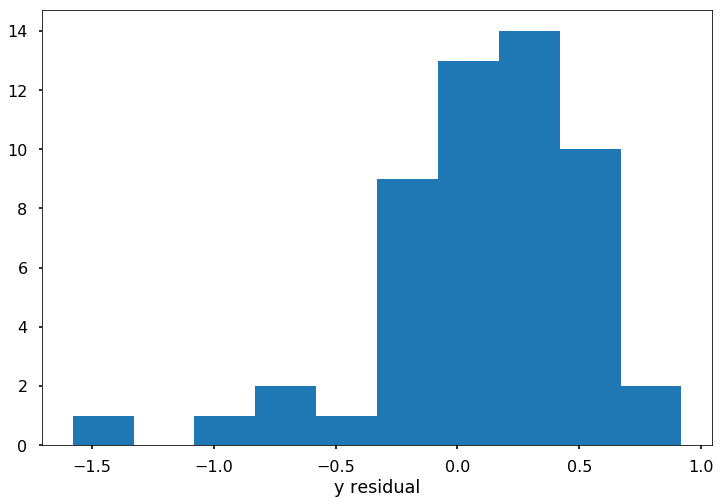

In [22]:
# plot residual histogram
plt.figure(figsize = (12, 8))
plt.hist(y_pred-y_test)
plt.xlabel('y residual')

# A deep learning model with direct waveform input

In [23]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [24]:
X = waveforms
for i in range(X.shape[0]):
    X[i] = X[i]/np.max(np.std(X[i]))

In [25]:
X.shape

(265, 3, 300)

In [26]:
y.shape

(265,)

In [27]:
X = X[:, :, :, np.newaxis] # This treat 1D time series as 2D images by adding one more dimension
input_shape = (X.shape[1], X.shape[2], 1)

In [28]:
X.shape

(265, 3, 300, 1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7) # Train/test split

In [30]:
# Modified from the classifcation example
inputs = Input(input_shape)
x = Conv2D(8, (1, 3), activation='relu')(inputs)
x = MaxPooling2D((1, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='linear')(x) # Last output should be a scalar for regression
model = Model(inputs = inputs, outputs = out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 300, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 298, 8)         32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 149, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 149, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3576)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                57232     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

In [31]:
batch_size = 8
epochs = 20

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mse']) # metrics MSE for regression

# use 20% of the training data as validation
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)

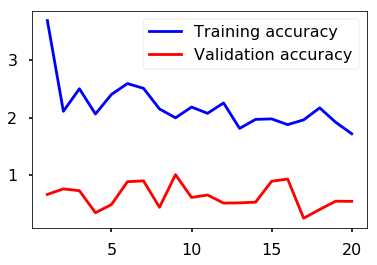

In [32]:
# plot training procedure
mse = history.history['loss']
val_mse = history.history['val_loss']
epochs_axis = range(1, len(mse) + 1)
plt.plot(epochs_axis, mse, 'b', label='Training accuracy')
plt.plot(epochs_axis, val_mse, 'r', label='Validation accuracy')
plt.legend()

In [33]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'y_pred')

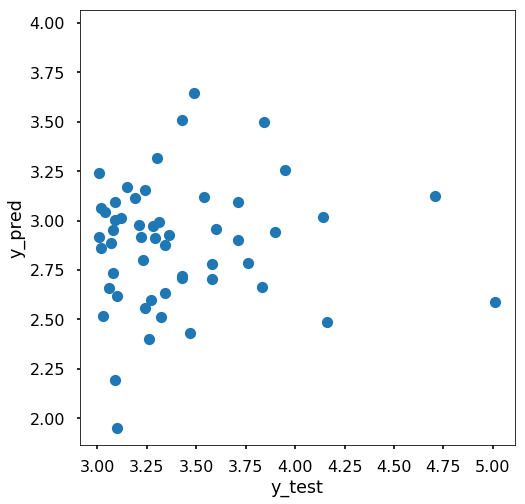

In [34]:
plt.figure(figsize = (12, 8))
plt.plot(y_test, y_pred, 'o')
plt.axis('square')
plt.xlabel('y_test')
plt.ylabel('y_pred')

## Reflect on why so poor performance
1. The task by itself is difficult. (Imagine to reason the magnitude by looking at a P wave)
2. Data set is too unbalanced (Few in large magnitude)
3. Data set is too small (only 256 events)
4. Too simple models (only 4 features for Random Forest, only a few layers in the NN)

![Example](http://web.gps.caltech.edu/~zefengli/transfer/Slides/Example.png)